# <center> Homelessness Among the U.S. States: an Exploration into Factors that may Influence Viability
    
#### This data analytics study seeks to investigate the varying conditions across the states of the U.S. that these analysts hypothesize make homelessness a more viable proposition. The conditions studied include public policy, sheltering resources, and weather/climate. For public policy, the analysts explore and seek to prove the working hypothesis: states with more laws restricting the activities of homeless persons (e.g., laws banning camping in public, sleeping in public, living in vehicles, loitering, and pandhandling), will have lower rates of homelessness. On the point of shelters available for homeless persons, the analysts hyptothesize that states with more shelter resources will have higher rates of homelessness than those with fewer. Regarding the exploration of weather/climate, these analysts hypothesize that states with milder weather conditions (i.e., those without an average indicating freezing or sweltering periods) demonstrate a correlation with increased homelessness numbers.

In [1]:
# %pwd
# Import the necessary python modules for our project

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import json
from datetime import datetime
import time
import requests
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import linregress
import numpy as np
import hvplot.pandas
from pathlib import Path

# Import needed APIs from local python files
from config import ncdc_api
headers = {"token":ncdc_api} #token from https://www.ncdc.noaa.gov/cdo-web/token
from api_keys import geoapify_key

In [2]:
# Paths for csv files
policy_data = ("2021-HNH-State-Crim-Supplement_Edited.csv")
population_data = ("Homeless Population by State.csv")
sheltered_data = ("2021-AHAR-Part-1_HomelessSheltered.csv")

# Read csv files
policy_data = pd.read_csv(policy_data)
population_data = pd.read_csv(population_data)
sheltered_data = pd.read_csv(sheltered_data)

In [3]:
# Merge all csv files from repository into single dataframe for project
policy_pop=pd.merge(policy_data, population_data, how="outer", on=["State"])
psp=pd.merge(policy_pop, sheltered_data, how="outer", on=["State"])

# Remove "NaN" results (District of Columbia). Weather code doesnt' work effectively with DC
psp=psp.dropna()

# Reset "states" variable to hold only usable values (no NaN)
# states=psps["State"]
psp.head()

,State,Sleeping in public state- wide,Sleeping in particular public places,Camping in public state- wide,Camping in particular public places,Sitting/lying in particular public places,"Lodging, living, or sleeping in vehicles (or parking a vehicle used as a lodging / living accom- modation)",Loitering / Loafing / Vagrancy state-wide,Loitering / Loafing in particular public places,Standing in Roadway,...,Per10kResidents,ChronicallyHomeless,PeopleInFamilyUnits,SoloIndividuals,UnaccompaniedYouths,Veterans,Sheltered Homeless Population,Individuals Sheltered,Families Sheltered,Unaccompanied Youth Sheltered
0,Alabama,False,False,False,False,False,False,True,True,True,...,7.4,539,1270,2482,169,308,1626.0,1165.0,461.0,55.0
1,Alaska,False,False,False,True,False,False,False,False,False,...,31.7,576,560,1760,186,134,1797.0,1295.0,502.0,195.0
2,Arizona,False,False,False,True,False,False,True,True,True,...,18.6,2476,2846,10707,917,857,5460.0,3304.0,2165.0,249.0
3,Arkansas,False,False,False,False,False,False,True,True,True,...,8.1,376,328,2131,251,92,1470.0,1204.0,266.0,129.0
4,California,False,False,True,True,True,False,False,True,True,...,43.7,57760,25538,145983,9590,10395,51429.0,32910.0,18519.0,2526.0


In [4]:
# Rename column headers to be more intelligible to readers
psp=psp.rename(columns={
    "Sleeping in public state- wide":"Sleeping in Public",\
    "Sleeping in particular public places":"Sleeping in Specific Public Areas",\
    "Camping in public state- wide":"Camping in Public",\
    "Camping in particular public places":"Camping in Specific Public Areas",\
    "Sitting/lying in particular public places":"Lying Down in Public",\
    "Lodging, living, or sleeping in vehicles (or parking a vehicle used as a lodging / living accom- modation)":\
    "Sleeping or Living in a Vehicle",\
    "Loitering / Loafing / Vagrancy state-wide":"Loitering",\
    "Loitering / Loafing in particular public places":\
    "Loitering in Specific Public Areas",\
    "Panhandling in public places state- wide":"Panhandling in Public",\
    "Panhandling in particular public places":\
    "Panhandling in Specific Public Areas",\
    "Total":"Total Homeless Population",\
    "Per10kResidents":"Homeless Per 10k Residents",\
    "ChronicallyHomeless":"Chronically Homeless",\
    "ChronicPer10k":"Chronically Homeless Per 10k"
})
# Save as DataFrame to for updated csv
psp_df=pd.DataFrame(psp)
psp_df.head()

,State,Sleeping in Public,Sleeping in Specific Public Areas,Camping in Public,Camping in Specific Public Areas,Lying Down in Public,Sleeping or Living in a Vehicle,Loitering,Loitering in Specific Public Areas,Standing in Roadway,...,Homeless Per 10k Residents,Chronically Homeless,PeopleInFamilyUnits,SoloIndividuals,UnaccompaniedYouths,Veterans,Sheltered Homeless Population,Individuals Sheltered,Families Sheltered,Unaccompanied Youth Sheltered
0,Alabama,False,False,False,False,False,False,True,True,True,...,7.4,539,1270,2482,169,308,1626.0,1165.0,461.0,55.0
1,Alaska,False,False,False,True,False,False,False,False,False,...,31.7,576,560,1760,186,134,1797.0,1295.0,502.0,195.0
2,Arizona,False,False,False,True,False,False,True,True,True,...,18.6,2476,2846,10707,917,857,5460.0,3304.0,2165.0,249.0
3,Arkansas,False,False,False,False,False,False,True,True,True,...,8.1,376,328,2131,251,92,1470.0,1204.0,266.0,129.0
4,California,False,False,True,True,True,False,False,True,True,...,43.7,57760,25538,145983,9590,10395,51429.0,32910.0,18519.0,2526.0


In [5]:
# Save compiled dataframe merge as singular csv for following analyses
psp_df.to_csv("psp.csv", index_label="State ID")

# Read csv into code
psp=("psp.csv")
psp=pd.read_csv(psp)

# Drop District of Columbia because 1) not a state and 2) it creates problems for code
psp=psp.drop(psp.index[8])

# <center> PART A: The Effect of Laws Restricting Homeless Activities on the Rate of Homelessness By State
#### The first part of this homelessness study explores whether state laws (i.e., laws banning camping in public, sleeping in public, living in vehicles, loitering, and pandhandling) and the restrictions they impose on homeless activites have an effect on overall homelessness rates across the states of the U.S.

The working hypothesis in this section is that states with more laws restricting the activity of homeless persons, as listed above, will have lower rates of homelessness than states with more "lax" laws. This section of the study seeks to determine whether this hypothesis is probable or whether the null hypothesis, that laws restricting homeless persons' activity do not have a measurable effect on rates of homelessness, is more likely.
    
Note: "Restrictiveness Score" is a variable developed by our team to quantify the extent to which a state has laws restricting the activities of homeless persons. The score is based on the count of "True" values, with higher counts indicating a higher "Restrictiveness Score".

In [6]:
# Create ChronicPer10k column to measure chronic homeless population per 10,000 residents
psp["Chronically Homeless Per 10k"] = \
    psp["Homeless Per 10k Residents"] * psp["Chronically Homeless"] / psp["Total Homeless Population"]

In [7]:
# Use .loc method to get pertinent columns we will need to do statistical hypothesis testing on
psp_laws = psp.loc[:, ["State","Restrictiveness Score","Total Homeless Population","Homeless Per 10k Residents","Chronically Homeless","Chronically Homeless Per 10k"]]
psp_laws.head(3)

,State,Restrictiveness Score,Total Homeless Population,Homeless Per 10k Residents,Chronically Homeless,Chronically Homeless Per 10k
0,Alabama,6,3752,7.4,539,1.063060
1,Alaska,1,2320,31.7,576,7.870345
2,Arizona,6,13553,18.6,2476,3.398037


## <center> Scatter Plots and Linear Regression Analyses

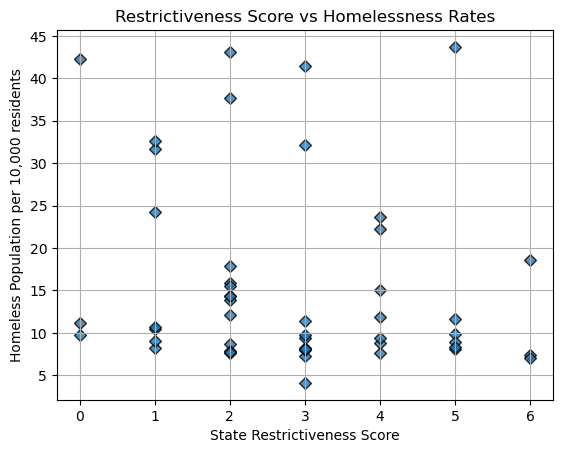

In [8]:
# Create plot showing rate of homelessness per 10K residents in each state by "Restrictiveness Score"
plt.scatter(     
    psp_laws["Restrictiveness Score"],
    psp_laws["Homeless Per 10k Residents"],
    edgecolor="black",
    linewidths=1,
    marker="D", 
    alpha=0.8,
)

# Augment
plt.title("Restrictiveness Score vs Homelessness Rates")
plt.xlabel("State Restrictiveness Score")
plt.ylabel("Homeless Population per 10,000 residents")
plt.grid(True)

# Show plot
plt.show()

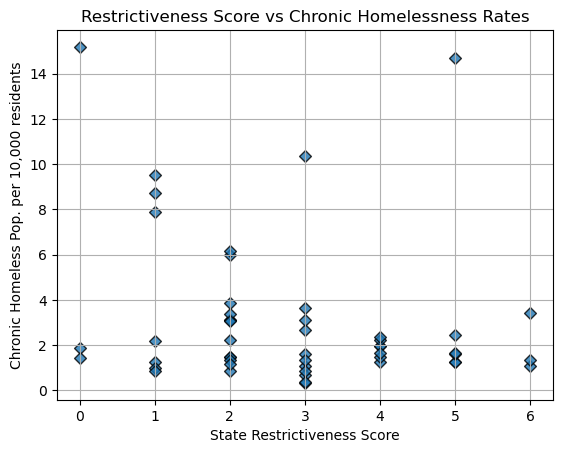

In [9]:
# Create plot state showing  rate of chronic homelessness per 10K residents in each state by "Restrictiveness Score"
plt.scatter(     
    psp_laws["Restrictiveness Score"],
    psp_laws["Chronically Homeless Per 10k"],
    edgecolor="black",
    linewidths=1,
    marker="D", 
    alpha=0.8,
    #label="Cities"
)

# Augment
plt.title("Restrictiveness Score vs Chronic Homelessness Rates")
plt.xlabel("State Restrictiveness Score")
plt.ylabel("Chronic Homeless Pop. per 10,000 residents")
plt.grid(True)

# Show plot
plt.show()

## Function plot_linear_regression to derive correlations throughout study

In [10]:
# Create function to calculate linear regression that will be used throught the study to
# derive and plot correlations

#define the function
def plot_linear_regression(x_values, y_values, x_axis, title, text_coordinates):
    
    # Compute linear regression
    (slope, intercept, rvalue, pvalue, sterr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot
    plt.scatter(x_values,y_values, marker="D")
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,text_coordinates,fontsize=15,color="black")
    plt.xlabel(x_axis)
    plt.ylabel(title)
    print(f"The r² value is: {rvalue**2}")
    print(f"The r value is: {rvalue}")
    print(f"The p value is: {pvalue}")
    plt.grid(True)

The r² value is: 0.0335928735934168
The r value is: -0.18328358789978114
The p value is: 0.20264377437937456


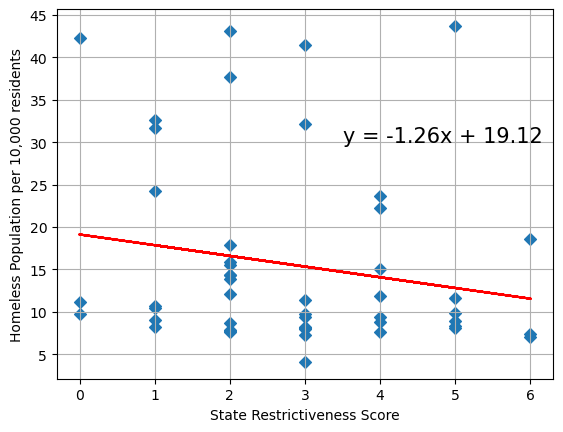

In [11]:
# Linear regression on Per10Residents Homeless compared to Restrictiveness Score
x_values = psp_laws["Restrictiveness Score"]
y_values = psp_laws["Homeless Per 10k Residents"]
plot_linear_regression(x_values, y_values, "State Restrictiveness Score", "Homeless Population per 10,000 residents", (3.5,30))

With this regression, it can be seen that there is a small negative correlation between rates of homelessness per capita compared to the state's "Restrictiveness Score". Rates of homelessness seem to be *slightly* lower when there is more legislation restricting homeless persons' activities, but the correlation is very small with an r-value of -0.18. Moreover, the p-value of 0.20 is greater than the conventional threshold of 0.05 needed to jettison our null hypothesis. Therefore, it cannot be determined from the data displayed that a clear relationship between number of laws in a state and the per capita rate of homelessness exists. More data and analysis would be needed to support such a hypothesis.

The r² value is: 0.04323939458059574
The r value is: -0.20794084394508872
The p value is: 0.14731879273950507


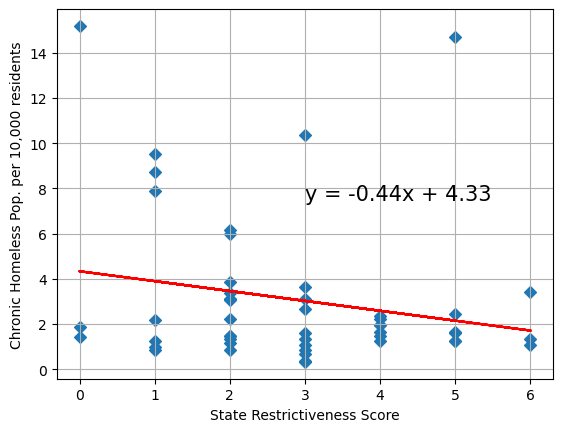

In [12]:
# Linear regression on Chronic Per10Residents Homeless compared to Restrictiveness Score
x_values = psp_laws["Restrictiveness Score"]
y_values = psp_laws["Chronically Homeless Per 10k"]
plot_linear_regression(x_values, y_values, "State Restrictiveness Score", "Chronic Homeless Pop. per 10,000 residents", (3,7.5))

The above comparison shows a *slightly* higher negative correlation between a state's "Restrictiveness Score" and rates of chronic homeless persons per capita. However, the correlation, with an r value of -0.21, is still very low. Furthermore, the p-value of 0.14 is still above the .05 threshold required to dismiss the null hypothesis.

# <center> PART B: The Effect of Availability of Homeless Sheltering on the Rate of Homelessness By State
#### The second part of this study will focus on whether increased access to shelter for homeless persons has an effect on overall homeless rates across states of the U.S.
The working hypothesis in this section is that states with greater access to shelter resources for the homeless will have greater rates of homelessness overall. This analysis seeks to determine whether this hypothesis is probable or whether the null hypothesis, that access to shelter provided for the homeless will not have any effect on overall homeless rates, is more likely.

In [13]:
# Calculate needed columns using main csv for analyses

# Sheltered per capita
psp["Sheltered Per 10k Residents"] = \
    psp["Homeless Per 10k Residents"] * psp["Sheltered Homeless Population"] / psp["Total Homeless Population"]
# Percent sheltered
psp["Percent of Homeless Population Sheltered"] = \
    psp["Sheltered Homeless Population"] / psp["Total Homeless Population"] *100

In [14]:
# Use .loc method to get pertinent columns we will need to do statistical hypothesis testing on
psp_shelter = psp.loc[:, ["State","Total Homeless Population","Sheltered Homeless Population","Homeless Per 10k Residents", "Sheltered Per 10k Residents", "Percent of Homeless Population Sheltered"]]
psp_shelter.head(3)

,State,Total Homeless Population,Sheltered Homeless Population,Homeless Per 10k Residents,Sheltered Per 10k Residents,Percent of Homeless Population Sheltered
0,Alabama,3752,1626.0,7.4,3.206930,43.336887
1,Alaska,2320,1797.0,31.7,24.553836,77.456897
2,Arizona,13553,5460.0,18.6,7.493249,40.286283


# <center> Scatter Plots and Linear Regression Analyses

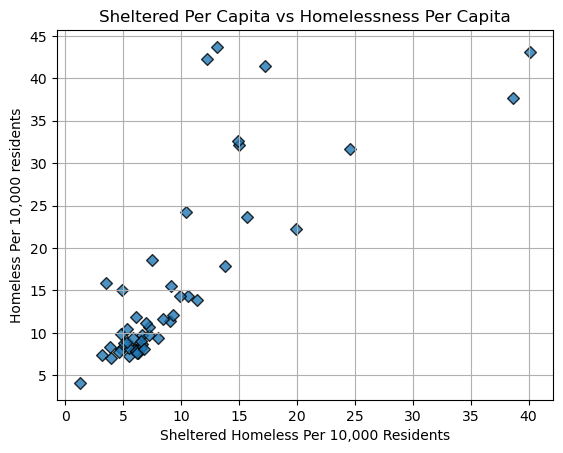

In [15]:
# Create plot showing relationship between sheltered homeless per capita and homeless per capita

plt.scatter(     
    psp_shelter["Sheltered Per 10k Residents"],
    psp_shelter["Homeless Per 10k Residents"],
    edgecolor="black",
    linewidths=1,
    marker="D", 
    alpha=0.8,
)

# Augment
plt.title("Sheltered Per Capita vs Homelessness Per Capita")
plt.xlabel("Sheltered Homeless Per 10,000 Residents")
plt.ylabel("Homeless Per 10,000 residents")
plt.grid(True)

# Show plot
plt.show()

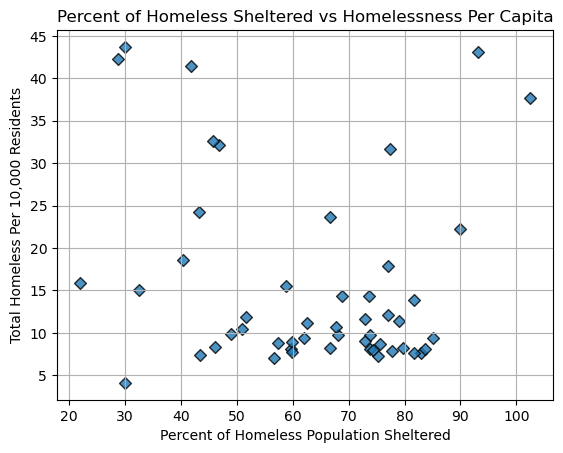

In [16]:
# Create plot showing relationship between sheltered percent of homeless population
# and chronic homeless population rate

plt.scatter(     
    psp_shelter["Percent of Homeless Population Sheltered"],
    psp_shelter["Homeless Per 10k Residents"],
    edgecolor="black",
    linewidths=1,
    marker="D", 
    alpha=0.8,

)

# Augment
plt.title("Percent of Homeless Sheltered vs Homelessness Per Capita")
plt.xlabel("Percent of Homeless Population Sheltered")
plt.ylabel("Total Homeless Per 10,000 Residents")
plt.grid(True)


# Show plot
plt.show()

The r² value is: 0.6094155229239205
The r value is: 0.780650704812287
The p value is: 2.3033210836176268e-11


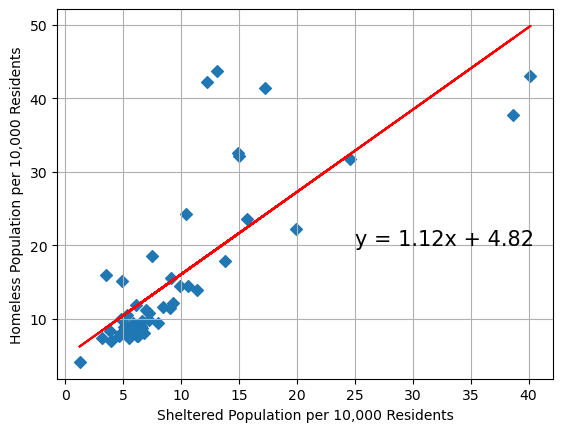

In [17]:
# Linear regression of homeless per capita by state compared to sheltered homeless per capita by state
x_values = psp_shelter["Sheltered Per 10k Residents"]
y_values = psp_shelter["Homeless Per 10k Residents"]
plot_linear_regression(x_values, y_values, "Sheltered Population per 10,000 Residents", "Homeless Population per 10,000 Residents", (25,20))

With this regression, it is evident that there is a strong positive correlation between homelessness per capita compared to homeless persons sheltered per capita in the states. Furthermore, the p-value is well below the threshold of 0.05. With this information, the null hypothesis that posits no relationship exists between homeless peoples sheltered per capita and homeless peoples per capita, can be rejected. Therefore, one can conclude that the working (alternative) hypothesis is correct and there is a clear demonstrable relationship between the two variables.

The r² value is: 0.02585309125713546
The r value is: -0.16078896497314565
The p value is: 0.26464924014855074


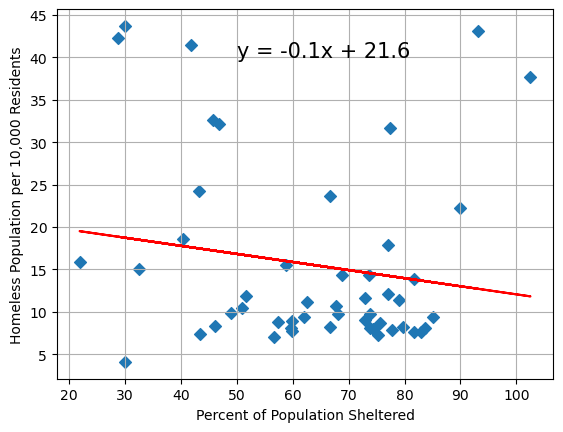

In [18]:
# Linear regression comparing homeless per capita and percent homeless sheltered by state
x_values = psp_shelter["Percent of Homeless Population Sheltered"]
y_values = psp_shelter["Homeless Per 10k Residents"]
plot_linear_regression(x_values, y_values, "Percent of Population Sheltered", "Homeless Population per 10,000 Residents", (50,40))

The above linear regression analysis shows that there is very little statistically significant relationship between homeless peoples per capita and the percentage of the homeless population that is sheltered. With a *quite* low r² value and a p-value of 0.26, higher than the conventional threshold, that conclusion is justified without additional information.

# <center> PART C: Analysis of the effects of Average State Temperature (F) and weather patterns on homeless population by state
#### The third part of this analysis aims to investigate the potential relationship between the average temperature per state within the U.S. and the homeless population, per capita, of the corresponding state.
The working hypothesis of this section is that states with more favorable weather will have greater rates of homelessness. This analysis serves to determine whether this hypothesis is probable or whether the null hypothesis, that weather has no effect on overall homeless rates, is more likely.
    
Note: The following cell containing "fetch_temperature_data" was built with the aid of an AI language model. An original code was constructed to pull the Average Temperature, but would overload the site. This code, while more efficient, does not have a perfect success rate.

In [19]:
# Define function to fetch temperature data per state

def fetch_temperature_data(state):
    # Existing code from original
    # Define variables with NOAA specific calls
    datasetid = 'GSOY' #Global Summary of Year
    datatypeid = 'TAVG' #Average Temperature
    locationid = state['id'] #State ID
    units = 'standard' #Units for Temperature (F)
    startdate = '2021-01-01' #Start Date of Requested Data
    enddate = '2021-12-31' #End Date of Requested Data (going over entire year breaks code)
    limit = '1000' #Limit for Data 
    
    # NOAA url with embedded variables
    url = f"https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid={datasetid}&datatypeid={datatypeid}&locationid={locationid}&units={units}&startdate={startdate}&enddate={enddate}&limit={limit}"
    
    # API request and store data
    r = requests.get(url, headers=headers).text
    response = json.loads(r)
    
    # Set temp avg at 0
    tavg = 0
    if "results" in response:
        
        # Run through results and gather temperature values 
        for result in response['results']:
            tavg += result['value']
        # Find avg of all NOAA stations' temp data per state
        tavg = tavg / len(response['results'])
    else:
        tavg=None
    time.sleep(1)  # Limit request per second
    
    # Return dictionary with state name and average temperature
    return {"State": state['name'], "Average Temp (F)": tavg}

# Main script
if __name__ == '__main__':
    
    # Get state information and store in "states" variable
    state_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=52"
    state_response = requests.get(state_url, headers=headers).text
    states = json.loads(state_response)['results']

    # ThreadPoolExecutor used to fetch temperature data for each state concurrently
    # Ddjust max_workers (number of simultaneous requests) as needed
    with ThreadPoolExecutor(max_workers=3) as executor:  
        weather_data = list(executor.map(fetch_temperature_data, states))

    # Weather_data now contains the temperature data for all states
    
print("Done")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
# Ensure data pulled successfully and turn list into df
psp_weather=pd.DataFrame(weather_data)
# Remove NaN results (DC). API code didn't like it
psp_weather=psp_weather.dropna()
# Create csv of new data
#psp_weather.to_csv("weather.csv", index_label="State_ID")
#psp_weather=pd.read_csv("weather.csv")
# Reset "states" variable to hold only wanted values (no NaN)
states=psp_weather["State"]

In [ ]:
# Create Avg Temperature column to put pulled data in
psp["Average Temperature (F)"] = psp_weather["Average Temp (F)"]

### <center>Selective Data Reasoning
The following datasets will compare homelessness per capita to the average temperature of the corresponding US state. To include "total" homless population as opposed to "per capita", could result in skewed data.

In [ ]:
# Reusing psp_weather
# Use loc method to get desired columns for statistical hypothesis testing
psp_weather = psp.loc[:, ["State", "Total Homeless Population", "Homeless Per 10k Residents", "Average Temperature (F)"]]
psp_weather.head(3)

# <center> Scatter Plots and Linear Regression Analysis
The charts below display the relationship between a U.S. state's average temperature and the homeless population per capita.

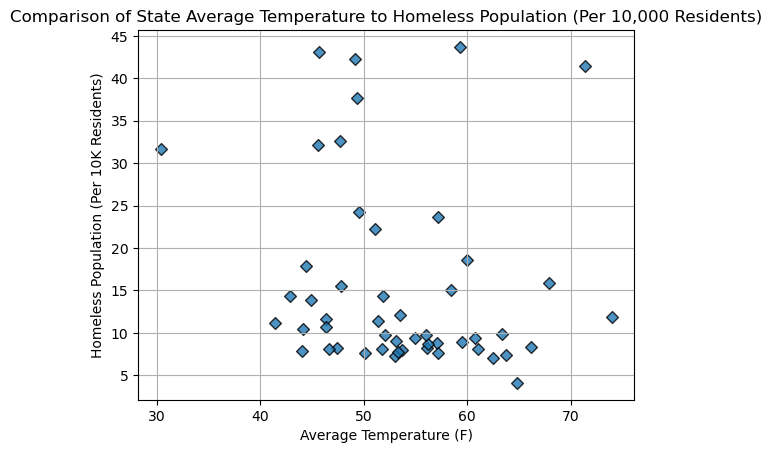

In [26]:
# create scatter plot to display data

plt.scatter(
    psp_weather["Average Temperature (F)"],
    psp_weather["Homeless Per 10k Residents"],
    edgecolor="black",
    linewidths=1,
    marker="D",
    alpha=0.8
)

plt.title("Comparison of State Average Temperature to Homeless Population (Per 10,000 Residents)")
plt.xlabel("Average Temperature (F)")
plt.ylabel("Homeless Population (Per 10K Residents)")
plt.grid(True)
plt.show()

The r² value is: 0.029395602353654664
The r value is: -0.17145145771808026
The p value is: 0.23384166315338337


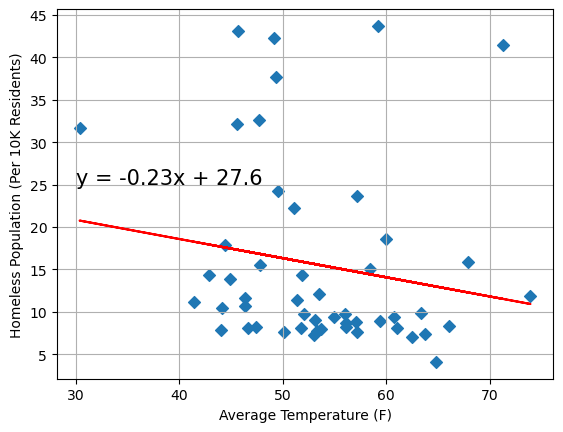

In [27]:
# Creating linear regression for data
x_values = psp_weather["Average Temperature (F)"]
y_values = psp_weather["Homeless Per 10k Residents"]
plot_linear_regression(x_values, y_values, "Average Temperature (F)", "Homeless Population (Per 10K Residents)", (30,25))

As the linear regression analysis shows, there is a weak negative correlation between a state's average temperature and it's homeless population per capita. This result suggests that, on average, states with a higher average temperature tend to have a lower homeless population per capita. However the p-value is well above the conventional threshold to needed to jettison our null hypothesis, so a clear relationship between the two variables cannot be established without further information.

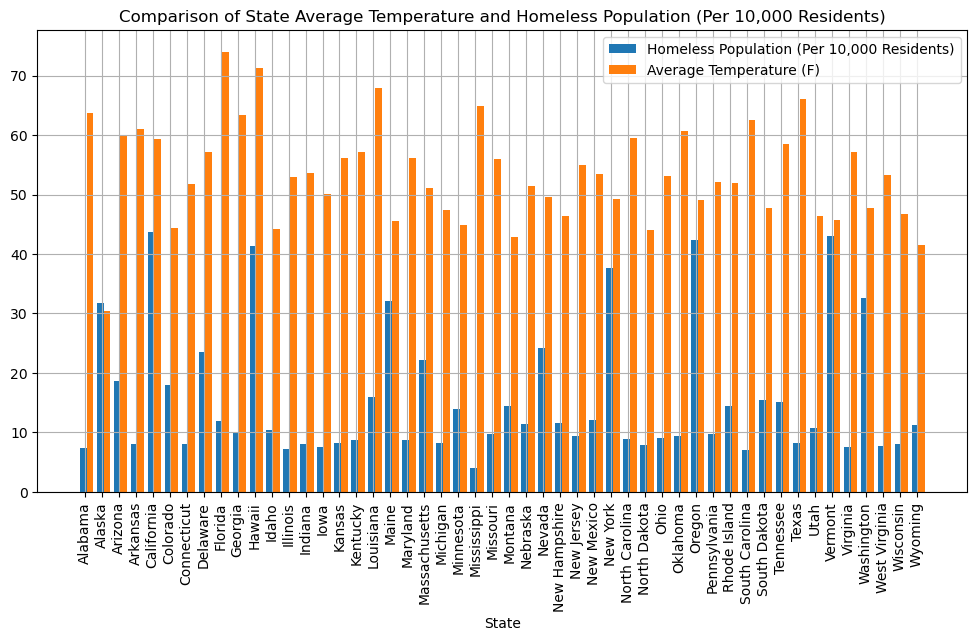

In [28]:
plt.figure(figsize=(12,6))
x=range(len(states))
width=0.4

# Create bar graph to show side-by-side comparison of homeless population and average temperature per state 
plt.bar(x, psp_weather["Homeless Per 10k Residents"], width, label = "Homeless Population (Per 10,000 Residents)")
plt.bar([i+width for i in x], psp_weather["Average Temperature (F)"], width, label = "Average Temperature (F)")
plt.title("Comparison of State Average Temperature and Homeless Population (Per 10,000 Residents)")
plt.xlabel("State")

# Label on y-axis unnecessary with provided legend 
plt.ylabel("")

# Make state names readable by changing rotation
plt.xticks([i+width/4 for i in x], states, rotation="vertical")
plt.legend()
plt.grid(True)
plt.show()

## <center> Weather Findings
This analysis provides insight into the variation of average temperatures and homeless populations across the U.S. states. The findings of this analysis do show a negative, yet unremarkable correlation between the two variables. It is important to note that not all mitigating factors have been explored. Further investigation into severe climate instances, available housing, state-specific legislation, etc. would be needed to determine a comprehensive and conclusive result.

# <center> PART D: Comprehensive and Interactive Display of all Data Explored

#  Begin Looking For State Lon and Lat

In [29]:
# https://geoviews.org/user_guide/Working_with_Bokeh.html#wmts-tile-sources
# https://hvplot.holoviz.org/user_guide/Geographic_Data.html

# Created target_state filled will city, state Information for all 51 States
target_state = ['Montgomery, Alabama','Juneau, Alaska',
    'Little Rock, Arkansas','Phoenix, Arizona','Sacramento, California',
    'Denver, Colorado','Hartford, Connecticut','Washington, District of Columbia',
    'Dover, Delaware','Tallahassee, Florida','Atlanta, Georgia','Honolulu, Hawaii',
    'Des Moines, Iowa','Boise, Idaho','Springfield, Illinois','Indianapolis, Indiana',
    'Topeka, Kansas','Frankfort, Kentucky','Baton Rouge, Louisiana','Boston, Massachusetts',
    'Annapolis, Maryland','Augusta, Maine','Lansing, Michigan','St. Paul, Minnesota',
    'Jefferson City, Missouri','Jackson, Mississippi','Helena, Montana','Raleigh, North Carolina',
    'Bismarck, North Dakota','Lincoln, Nebraska','Concord, New Hampshire','Trenton, New Jersey',
    'Santa Fe, New Mexico','Carson City, Nevada','Albany, New York','Columbus, Ohio',
    'Oklahoma City, Oklahoma','Salem, Oregon','Harrisburg, Pennsylvania','Providence, Rhode Island',
    'Columbia, South Carolina','Pierre, South Dakota','Nashville, Tennessee','Austin, Texas',
    'Salt Lake City, Utah','Richmond, Virginia','Montpelier, Vermont','Olympia, Washington',
    'Madison, Wisconsin','Charleston, West Virginia','Cheyenne, Wyoming'
]
state_array = len(target_state)
#print(state_array)
#print(target_state)

## Loop each State through the api 

In [30]:
# COMPLETED LOOP FOR STATES and the coordinates 
state_cord = []

for x in range(state_array):
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_state[x]}&format=json&apiKey={geoapify_key}" 
    geo_data = requests.get(target_url).json()
    lat = geo_data["results"][0]["lat"]
    lon = geo_data["results"][0]["lon"]
    state_cord.append({"State": target_state[x],
                        "Lat": lat,
                        "Lon": lon})
    #print(target_state[x], lat, lon) #USED as a sign aswell
print("Done")      #USED as a sign to show all 51 States have made it through the API

Done


In [31]:
# Convert the Looped API data for each State into a dataframe
state_data_df = pd.DataFrame(state_cord)

# Split capital, state into sepreate collums 
state_data_df[['Capital', 'State']] = state_data_df['State'].str.split(', ', expand=True)

# store the newly split dataframe into a csv
state_data_df.to_csv("states_cords.csv", index_label= "State_ID")
#state_data_df.head(5)

## Test That Capital, State is Plotted 

In [33]:
# Using Dataframe from above Plot onto map

# Zoomed out look of capital, State plotted
map_lat_lon = state_data_df.hvplot.points( "Lon", "Lat", 
    geo = True, 
    scale = .1,                # can help with making bubbles smaller and larger
    color = "State",           # Easy way to distinguish the states
    alpha =  1,               # opaccity of the bubbles
    tiles = "OSM",            #"EsriImagery",  # makes it appear on tiles
    frame_width =700,
    frame_height = 300,   

# label the axis and title
    ylabel = ("Latitude"),
    xlabel = ("Longitude"),
    title = ("USA"),
    hover_cols = ['Capital']
)
map_lat_lon

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (State,Capital)

# ---------------------------------------------------------------------------------------------------------------

# Maps After The Final DataFrame Merge

In [34]:
# Import data for homeless policy and homeless population in two csv files
states_ = Path("states_cords.csv")
# Read coordinate csv files and store in Pandas dataframes
states_cords = pd.read_csv(states_)

## Data Merged with the Coordinates

In [35]:
# merging the lon and lat with dataframes filled with homelessness data
state_data = pd.merge(states_cords, psp_df, how="inner", on=["State", "State"])
state_data.head()

,State_ID,State,Lat,Lon,Capital,Sleeping in Public,Sleeping in Specific Public Areas,Camping in Public,Camping in Specific Public Areas,Lying Down in Public,...,Homeless Per 10k Residents,Chronically Homeless,PeopleInFamilyUnits,SoloIndividuals,UnaccompaniedYouths,Veterans,Sheltered Homeless Population,Individuals Sheltered,Families Sheltered,Unaccompanied Youth Sheltered
0,0,Alabama,32.366966,-86.300648,Montgomery,False,False,False,False,False,...,7.4,539,1270,2482,169,308,1626.0,1165.0,461.0,55.0
1,1,Alaska,58.301950,-134.419734,Juneau,False,False,False,True,False,...,31.7,576,560,1760,186,134,1797.0,1295.0,502.0,195.0
2,2,Arkansas,34.746507,-92.289627,Little Rock,False,False,False,False,False,...,8.1,376,328,2131,251,92,1470.0,1204.0,266.0,129.0
3,3,Arizona,33.448437,-112.074141,Phoenix,False,False,False,True,False,...,18.6,2476,2846,10707,917,857,5460.0,3304.0,2165.0,249.0
4,4,California,38.581061,-121.493895,Sacramento,False,False,True,True,True,...,43.7,57760,25538,145983,9590,10395,51429.0,32910.0,18519.0,2526.0


## Ploting Data Onto Each State

In [37]:
# Plot States_Data_df on the holoview plot
map_ = state_data.hvplot.points("Lon", "Lat", 
    geo = True, 
    scale = 1,          
    color = "State",         
    alpha =  1,               
    tiles = "OSM",  
    frame_width =700,
    frame_height = 300,
    ylabel = ("Latitude"),
    xlabel = ("Longitude"),
    title = ("States"), 
    hover_cols = ['Capital',"Total Homeless Population","Sheltered Homeless Population",
                  'Restrictiveness Score','Homeless Per 10k Residents','Chronically Homeless',
                  'PeopleInFamilyUnits','SoloIndividuals',"Individuals Sheltered",'UnaccompaniedYouths','Veterans']
)
map_

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (State,Capital,Total Homeless Population,Sheltered Homeless Population,Restrictiveness Score,Homeless Per 10k Residents,Chronically Homeless,PeopleInFamilyUnits,SoloIndividuals,Individuals Sheltered,UnaccompaniedYouths,Veterans)

# Zooming In, and Enhancing

In [38]:
pop_NA = state_data.hvplot.points( "Lon","Lat", 
    geo = True,                               
    size = "Total Homeless Population",  # data point we want to plot from state_data dataframe                  
    scale = .11,                # can help with making bubbles smaller and larger
    color = "State",           # Easy way to distinguish the states
    alpha =  1,               # opaccity of the bubbles
    tiles =  "OSM",  # CartoDark         # makes it appear on map
    frame_width =700,
    frame_height = 300,
                                  
# Display North America states 
    xlim =(-115, -80),
    ylim=(30, 49),
# label the axis and title
    ylabel = ("Latitude"),
    xlabel = ("Longitude"),
    title = ("Homeless Population in America"),
    hover_cols = ['Capital',"Total Homeless Population","Sheltered Homeless Population",
                  'Restrictiveness Score','Homeless Per 10k Residents','Chronically Homeless',
                  'PeopleInFamilyUnits','SoloIndividuals',"Individuals Sheltered",'UnaccompaniedYouths','Veterans']
)

In [39]:
pop_hawaii = state_data.hvplot.points("Lon", "Lat", 
    geo = True, 
    size = "Total Homeless Population",  # data point we want to plot  
    scale = .1,                # can help with making bubbles smaller and larger
    color = "State",           # Easy way to distinguish the states
    alpha = 1,                 # opaccity of the bubbles
    tiles = "OSM",  #"EsriNatGeo"           # makes it appear on map
    frame_width =700,
    frame_height = 300,
                                      
# Displays hawaii
    xlim =(-170, -145),
    ylim=(18, 24),
# label the axis and title
    ylabel = ("Latitude"),
    xlabel = ("Longitude"),
    title = ("Homeless Population in Hawaii"),
    hover_cols = ['Capital',"Total Homeless Population","Sheltered Homeless Population",
                  'Restrictiveness Score','Homeless Per 10k Residents','Chronically Homeless',
                  'PeopleInFamilyUnits','SoloIndividuals',"Individuals Sheltered",'UnaccompaniedYouths','Veterans']
)

In [40]:
# Plot Alaska on the holoview plot
pop_alaska = state_data.hvplot.points("Lon", "Lat", 
    geo = True, 
    size = "Total Homeless Population",  # data point we want to plot  
    scale = .1,                # can help with making bubbles smaller and larger
    color = "State",           # Easy way to distinguish the states
    alpha =  1,               # opaccity of the bubbles
    tiles = "OSM",  #"EsriNatGeo" # makes it appear on detailed map
    frame_width =700,
    frame_height = 300, 
                                      
# Displays alaska                                    
    xlim =(-130, -170),
    ylim=(50, 70), 
# label the axis and title                   
    ylabel = ("Latitude"),
    xlabel = ("Longitude"),
    title = ("Homeless Population in Alaska"),
    hover_cols = ['Capital',"Total Homeless Population","Sheltered Homeless Population",
                  'Restrictiveness Score','Homeless Per 10k Residents','Chronically Homeless',
                  'PeopleInFamilyUnits','SoloIndividuals',"Individuals Sheltered",'UnaccompaniedYouths','Veterans']
)

# Maps Fully Displayed

In [41]:
pop_NA
# Homeless Data for each state
# Bubble size = total homeless population

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (State,Total Homeless Population,Capital,Sheltered Homeless Population,Restrictiveness Score,Homeless Per 10k Residents,Chronically Homeless,PeopleInFamilyUnits,SoloIndividuals,Individuals Sheltered,UnaccompaniedYouths,Veterans)

In [42]:
pop_hawaii
# Homeless Data presented on Hawaii 
# Bubble size = total homeless population

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (State,Total Homeless Population,Capital,Sheltered Homeless Population,Restrictiveness Score,Homeless Per 10k Residents,Chronically Homeless,PeopleInFamilyUnits,SoloIndividuals,Individuals Sheltered,UnaccompaniedYouths,Veterans)

In [43]:
pop_alaska
# Homeless in Alaska 
# Bubble size = total homeless population

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (State,Total Homeless Population,Capital,Sheltered Homeless Population,Restrictiveness Score,Homeless Per 10k Residents,Chronically Homeless,PeopleInFamilyUnits,SoloIndividuals,Individuals Sheltered,UnaccompaniedYouths,Veterans)